In [17]:
import numpy as np 
import pandas as pd 

import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
sns.set()

from sklearn.mixture import GaussianMixture
from sklearn.preprocessing import RobustScaler
from sklearn.model_selection import StratifiedKFold

In [3]:
random_state = 42
np.random.seed(random_state)
df_train = pd.read_csv('data/train.csv').drop("ID_code",axis=1)
df_test = pd.read_csv('data/test.csv')

In [9]:
col1 = 'var_80'
col2 = 'var_166'
N = 70000

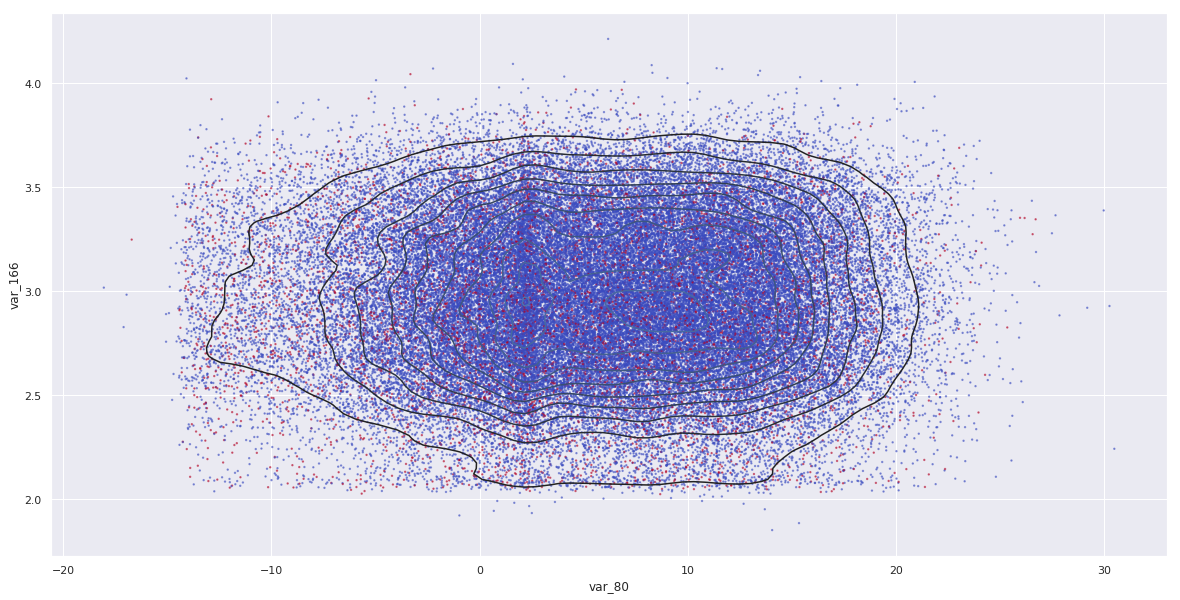

In [10]:
fig, ax = plt.subplots(1,1, figsize=(20,10))
sns.kdeplot(df_train[col1].values[0:N], df_train[col2].values[0:N])
ax.scatter(df_train[col1].values[0:N], df_train[col2].values[0:N],
           s=2, c=df_train.target.values[0:N], cmap="coolwarm", alpha=0.5)
ax.set_xlabel(col1)
ax.set_ylabel(col2);

In [46]:
original_features = df_train.drop(["target"], axis=1).columns.values
max_components = 10
start_components = 3
n_splits = 3
K = df_train.shape[0]

X = df_train.loc[:, original_features].values[0:K]
y = df_train.target.values[0:K]

In [47]:
seeds = np.random.RandomState(0).randint(0,100, size=(max_components-start_components))
seeds

array([44, 47, 64, 67, 67,  9, 83])

In [48]:
scaler = RobustScaler()
X_scaled = scaler.fit_transform(X)

In [ ]:
components = np.arange(start_components, max_components, 1)
kf = StratifiedKFold(random_state=0, n_splits=n_splits)

scores = np.zeros(shape=(max_components-start_components, n_splits))

for m in components:
    split=0
    print("Components " + str(m))
    for train_index, test_index in kf.split(X_scaled, y):
        print("Split " + str(split))
        x_train, x_test = X_scaled[train_index], X_scaled[test_index]
        gm = GaussianMixture(n_components=m, random_state=seeds[m-start_components])
        gm.fit(x_train)
        score = gm.score(x_test)
        scores[m-start_components,split] = score
        split +=1

print(np.round(np.mean(scores, axis=1), 2))
print(np.round(np.std(scores, axis=1), 2))
best_idx = np.argmax(np.mean(scores, axis=1))
best_component = components[best_idx]
best_seed = seeds[best_idx]
print("Best component found " + str(best_component))

Components 3
Split 0
Split 1
Split 2
Components 4
Split 0
Split 1
Split 2
Components 5
Split 0
Split 1
Split 2
Components 6
Split 0
Split 1
Split 2
Components 7
Split 0


In [51]:
best_component, best_seed

(3, 44)

In [52]:
gm = GaussianMixture(n_components=best_component, random_state=best_seed)
X_scaled = scaler.transform(X)
gm.fit(X_scaled)

GaussianMixture(covariance_type='full', init_params='kmeans', max_iter=100,
        means_init=None, n_components=3, n_init=1, precisions_init=None,
        random_state=44, reg_covar=1e-06, tol=0.001, verbose=0,
        verbose_interval=10, warm_start=False, weights_init=None)

In [53]:
X_test = df_test.loc[:, original_features]
X_test_scaled = scaler.transform(X_test)

In [54]:
df_train_temp = pd.read_csv('data/train.csv')

In [55]:
df_train_gauss = pd.DataFrame(index=df_train_temp.ID_code)
df_test_gauss = pd.DataFrame(index=df_test.ID_code)

In [56]:
df_train_gauss["cluster"] = gm.predict(X_scaled)
df_train_gauss["logL"] = gm.score_samples(X_scaled)
df_test_gauss["cluster"] = gm.predict(X_test_scaled)
df_test_gauss["logL"] = gm.score_samples(X_test_scaled)

In [57]:
df_train_gauss.head()

,cluster,logL
ID_code,,
train_0,0,-200.746476
train_1,1,-216.876389
train_2,2,-187.389335
train_3,1,-211.628666
train_4,2,-206.402731


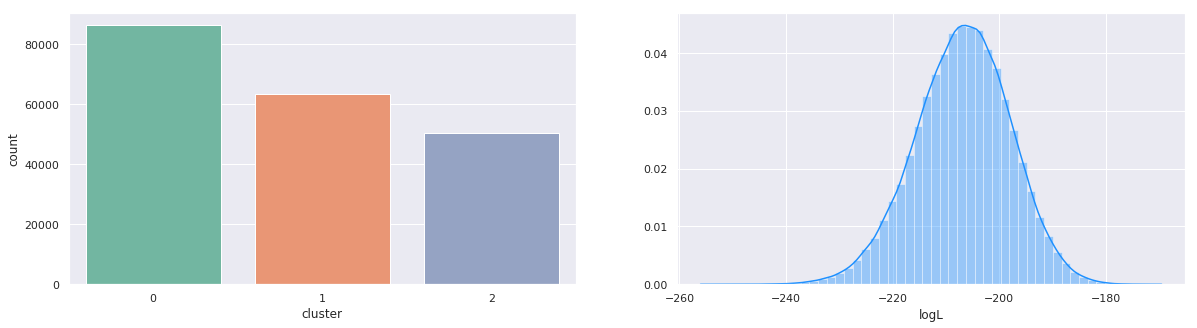

In [58]:
fig, ax = plt.subplots(1,2,figsize=(20,5))
sns.countplot(df_train_gauss.cluster, palette="Set2", ax=ax[0])
sns.distplot(df_train_gauss.logL, color="Dodgerblue", ax=ax[1]);

In [59]:
df_train_gauss.to_csv('data/train_gauss.csv')
df_test_gauss.to_csv('data/test_gauss.csv')